## Plotting

In [1]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase
from cea.config import Configuration
from cea_energy_hub_optimizer.my_config import MyConfig
from trustParetoFronts.pareto_analysis import ParetoFront

config = MyConfig(Configuration())

# Plot settings
plt.rcParams["font.family"] = "Roboto"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["legend.loc"] = "lower center"
plt.rcParams["legend.frameon"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.titley"] = 1.03
plt.rcParams["axes.linewidth"] = 2
plt.rcParams["xtick.major.width"] = 2  # setting the x-axis tick width globally
plt.rcParams["ytick.major.width"] = 2  # setting the y-axis tick width globally
# Set fig size
plt.rcParams["figure.figsize"] = (12, 8)
with_oil = False

In [ ]:
# prepare data
zone_path = config.locator.get_zone_geometry()
typology_path = config.locator.get_building_typology()
emission_systems_path = config.locator.get_building_air_conditioning()
if with_oil:
    pareto_fronts_path = os.path.join(
        config.locator.get_optimization_results_folder(),
        "calliope_energy_hub",
        "batch_with_oil",
    )
else:
    pareto_fronts_path = os.path.join(
        config.locator.get_optimization_results_folder(),
        "calliope_energy_hub",
        "batch_without_oil",
    )
zone_gdf: gpd.GeoDataFrame = gpd.read_file(zone_path)
zone_gdf["area"] = zone_gdf.geometry.area
zone_df = pd.DataFrame(zone_gdf).drop(columns="geometry").set_index("Name")
typology_df: pd.DataFrame = gpd.read_file(
    typology_path, ignore_geometry=True
).set_index("Name")
emission_system_df: pd.DataFrame = gpd.read_file(
    emission_systems_path, ignore_geometry=True
).set_index("Name")
zone_df = pd.concat([zone_df, typology_df, emission_system_df], axis=1, join="inner")
del typology_df, emission_system_df, zone_gdf

for building_name, row in zone_df.iterrows():
    area = float(row["area"])
    if not os.path.exists(
        os.path.join(pareto_fronts_path, f"{building_name}_pareto.csv")
    ):
        continue
    df_pareto = pd.read_csv(
        os.path.join(pareto_fronts_path, f"{building_name}_pareto.csv"),
        index_col=[0, 1],
    )
    emissions: np.array = df_pareto.loc[building_name, "emission"].values / area
    costs: np.array = df_pareto.loc[building_name, "cost"].values / area

    pf = ParetoFront(np.round(emissions, 3), np.round(costs, 3))
    zone_df.loc[building_name, "pf_slope"] = pf.slope()
    zone_df.loc[building_name, "pf_curvature"] = pf.curvature()
    zone_df.loc[building_name, "emission_range"] = pf.x_range()
    zone_df.loc[building_name, "cost_range"] = pf.y_range()

df_pareto_dict = {}
for building_name, row in zone_df.iterrows():
    if not os.path.exists(
        os.path.join(pareto_fronts_path, f"{building_name}_pareto.csv")
    ):
        continue
    df_pareto = pd.read_csv(
        os.path.join(pareto_fronts_path, f"{building_name}_pareto.csv"),
        index_col=[0, 1],
    )
    df_pareto_dict[building_name] = df_pareto
df_pareto_all = pd.concat(df_pareto_dict.values())
demand_color_dict = {
    "demand_space_heating_35": "gold",
    "demand_space_heating_85": "tab:red",
    "demand_hot_water": "tab:orange",
    "demand_electricity": "tab:green",
}

ls_supply_name = df_pareto_all.columns.difference(
    list(demand_color_dict.keys())
    + ["emission", "cost", "demand_space_heating_60", "demand_space_cooling"]
)
if not with_oil:
    ls_supply_name = ls_supply_name.difference(
        ["oil", "oil_boiler_large", "oil_boiler_middle", "oil_boiler_small"]
    )
df_pareto_all = df_pareto_all.merge(zone_df, left_on="building", right_index=True)

(-0.4728565471788153, 50.00286633075464)


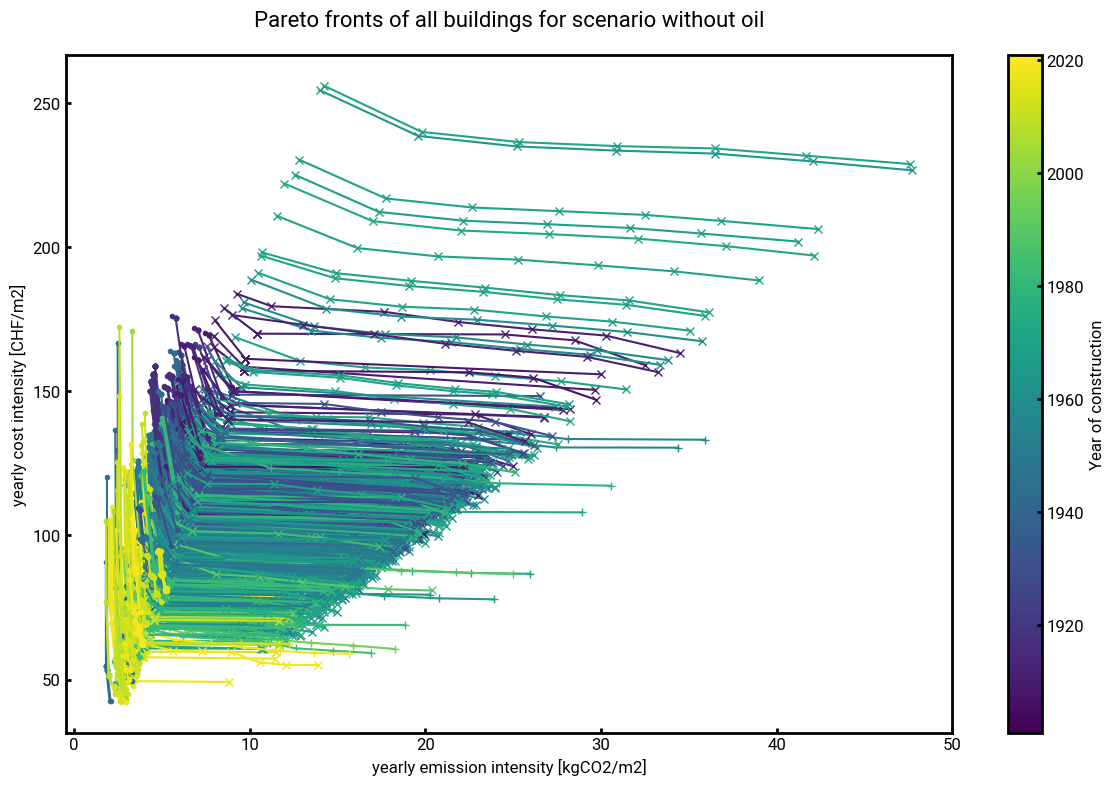

In [20]:
def cluster_by_shadow_price_and_reduction_potential(x, y):
    if x < 0.2:
        return 0
    elif y < -100 / 3 * x + 120:
        return 1
    else:
        return 2


cluster_markers = {
    0: ".",
    1: "x",
    2: "+",
}
fig1, ax1 = plt.subplots()
year_min = df_pareto_all["YEAR"].min()
year_max = df_pareto_all["YEAR"].max()
year_norm = mcolors.Normalize(vmin=year_min, vmax=year_max)
colormap = plt.get_cmap("viridis")  # type: ignore
for building_name in df_pareto_all.index.get_level_values(0).unique():
    df_pareto = df_pareto_all.loc[building_name]
    # pareto front has two levels of index, the first one is the building name and second one is the pareto front number starting from 0
    emissions = df_pareto["emission"].values
    costs = df_pareto["cost"].values
    area = df_pareto[
        "area"
    ].mean()  # area is the same for all pareto fronts of the same building
    pf = ParetoFront(np.round(emissions / area, 3), np.round(costs / area, 3))
    cluster = cluster_by_shadow_price_and_reduction_potential(
        1 / pf.slope(), pf.x_range(rel=True) * 100
    )
    df_pareto_all.loc[building_name, "cluster"] = cluster
    ax1.plot(
        emissions / area,
        costs / area,
        label=building_name,
        marker=cluster_markers[cluster],
        color=colormap(year_norm(zone_df["YEAR"].loc[building_name])),
    )
cbar1 = fig1.colorbar(plt.cm.ScalarMappable(cmap=colormap, norm=year_norm), ax=ax1, orientation="vertical")  # type: ignore
cbar1.set_label("Year of construction")
ax1.set_xlabel("yearly emission intensity [kgCO2/m2]")
ax1.set_ylabel("yearly cost intensity [CHF/m2]")
print(ax1.get_xlim())
if with_oil:
    ax1.set_title("Pareto fronts of all buildings for scenario with oil")
else:
    ax1.set_title("Pareto fronts of all buildings for scenario without oil")
fig1.tight_layout()

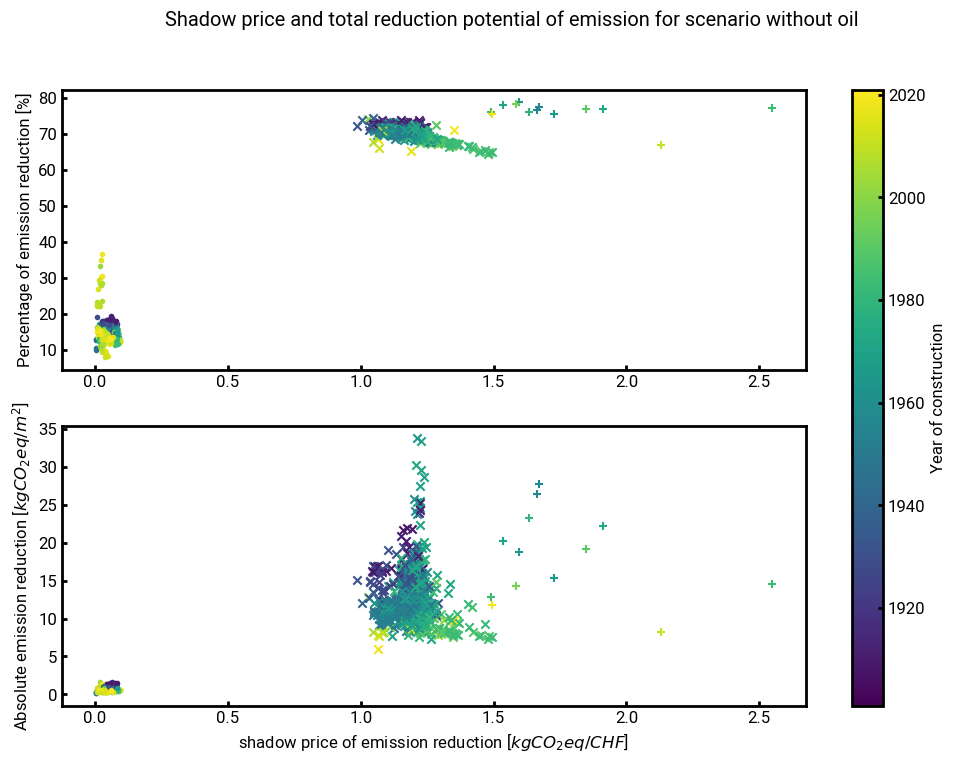

In [22]:
fig2, axes = plt.subplots(2, 1)
for idx, ax in enumerate(axes):
    for building_name in df_pareto_all.index.get_level_values(0).unique():
        df_pareto = df_pareto_all.loc[building_name]
        emissions = df_pareto["emission"].values
        costs = df_pareto["cost"].values
        area = df_pareto[
            "area"
        ].mean()  # area is the same for all pareto fronts of the same building
        pf = ParetoFront(np.round(emissions / area, 3), np.round(costs / area, 3))
        cluster = df_pareto["cluster"].unique()[0]
        dx = 1 / pf.slope()
        if idx == 0:  # plotting relative emission reduction
            dy = pf.x_range(rel=True) * 100
            ax.set_ylabel("Percentage of emission reduction [%]")
        else:  # idx=1, second subplot, plotting absolute emission reduction
            dy = pf.x_range()
            ax.set_ylabel("Absolute emission reduction [$kgCO_2eq/m^2$]")

        building_year = zone_df["YEAR"].loc[building_name]
        building_color = colormap(year_norm(building_year))
        ax.scatter(dx, dy, marker=cluster_markers[cluster], color=building_color)

axes[0].sharex(axes[1])
axes[1].set_xlabel("shadow price of emission reduction [$kgCO_2eq/CHF$]")
cbar2 = fig2.colorbar(plt.cm.ScalarMappable(cmap=colormap, norm=year_norm), ax=axes, orientation="vertical")  # type: ignore
cbar2.set_label("Year of construction")
if with_oil:
    fig2.suptitle(
        "Shadow price and total reduction potential of emission for scenario with oil"
    )
else:
    fig2.suptitle(
        "Shadow price and total reduction potential of emission for scenario without oil"
    )

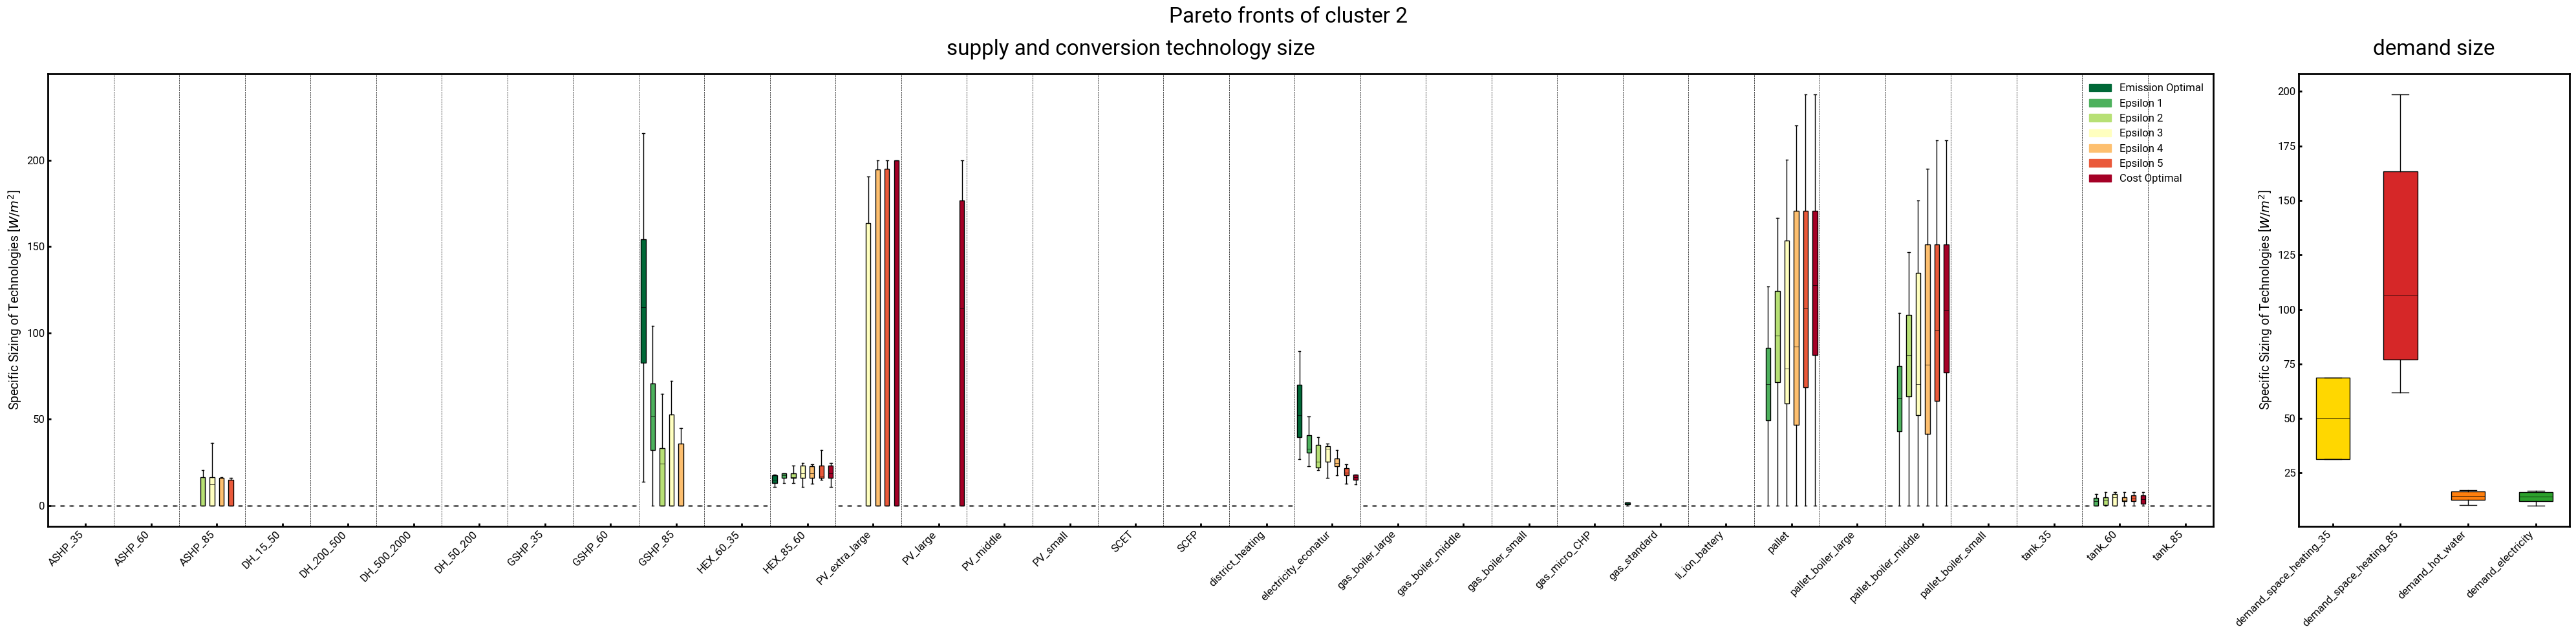

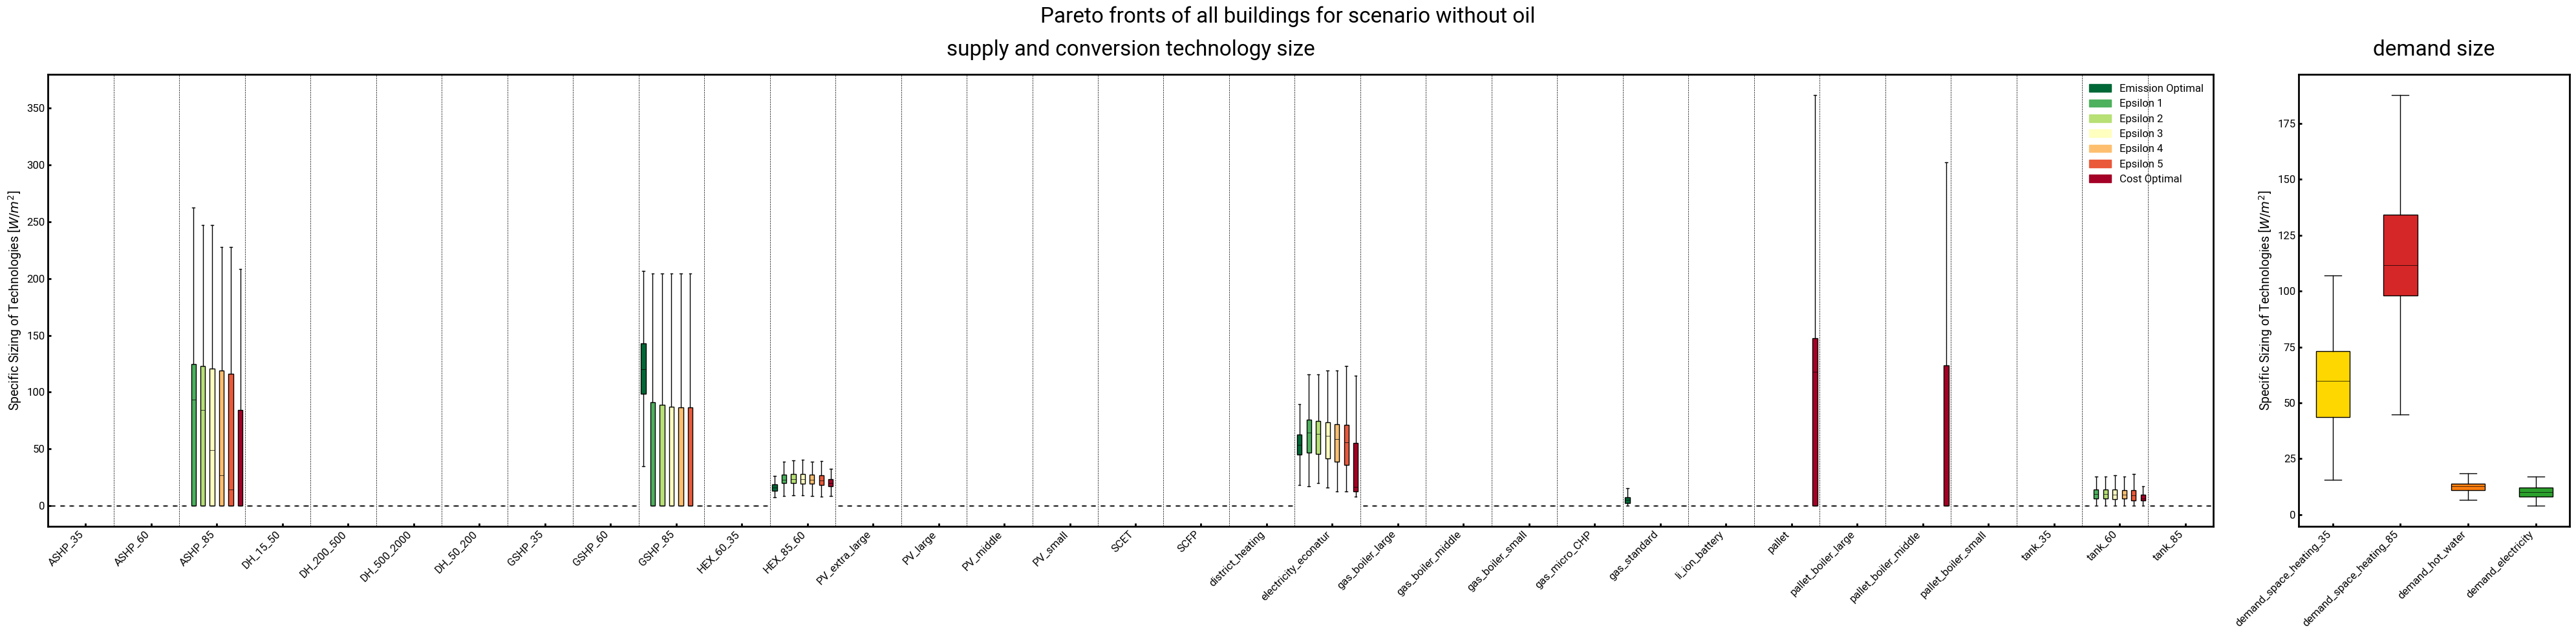

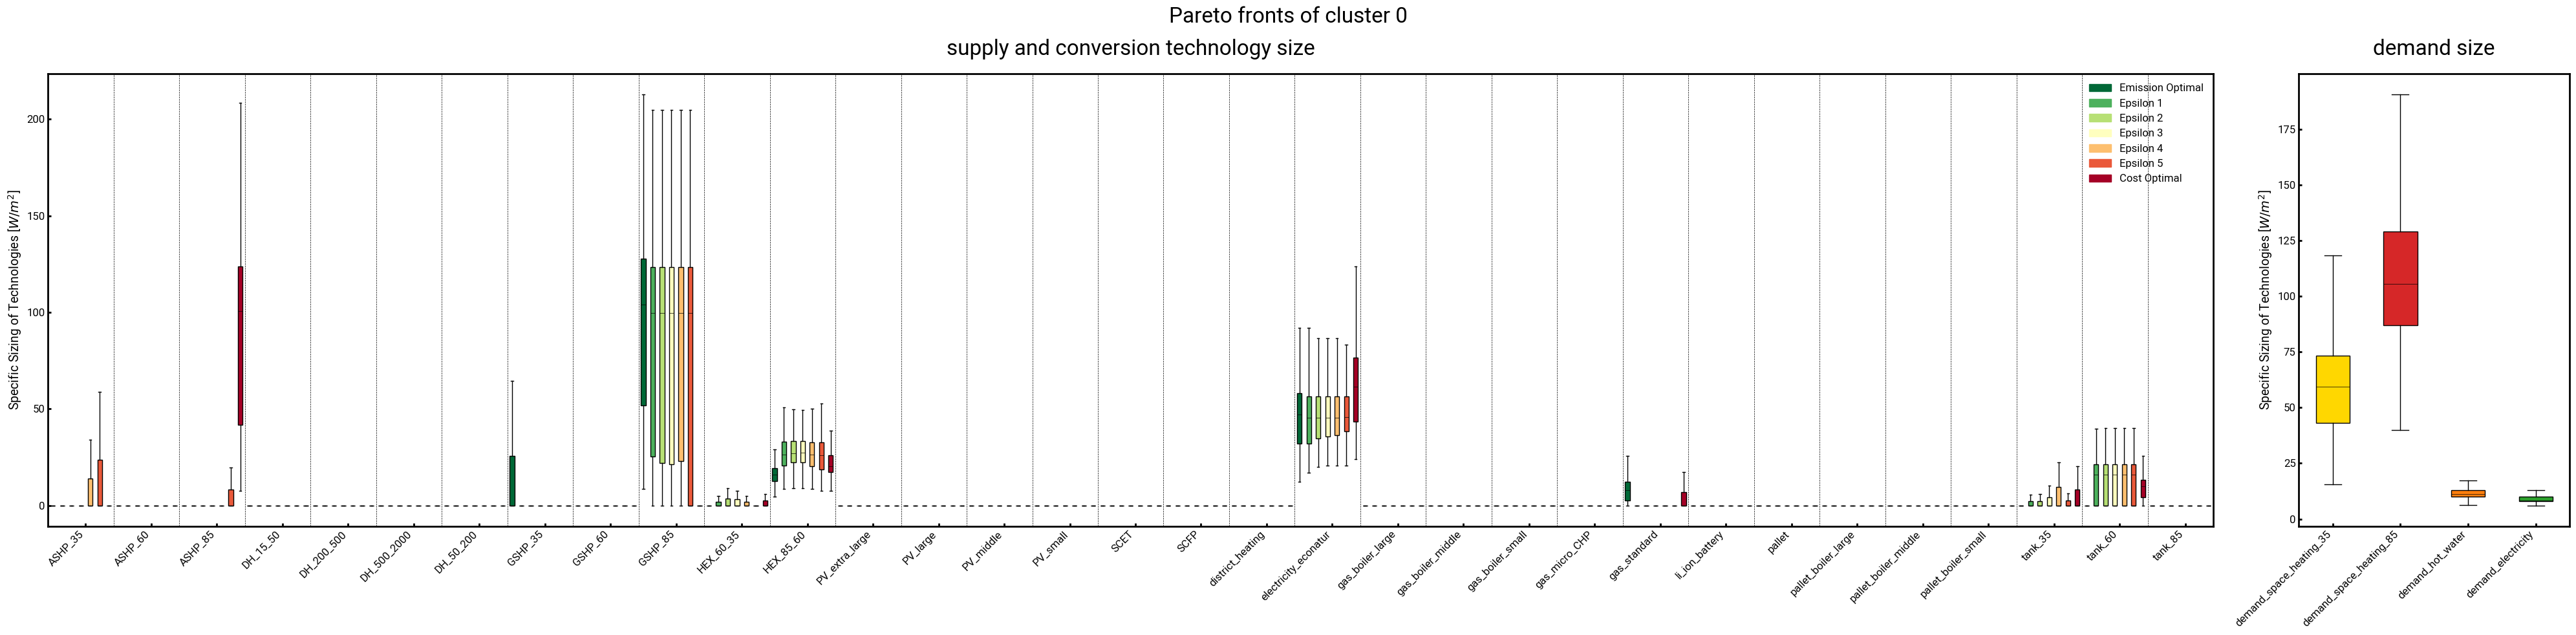

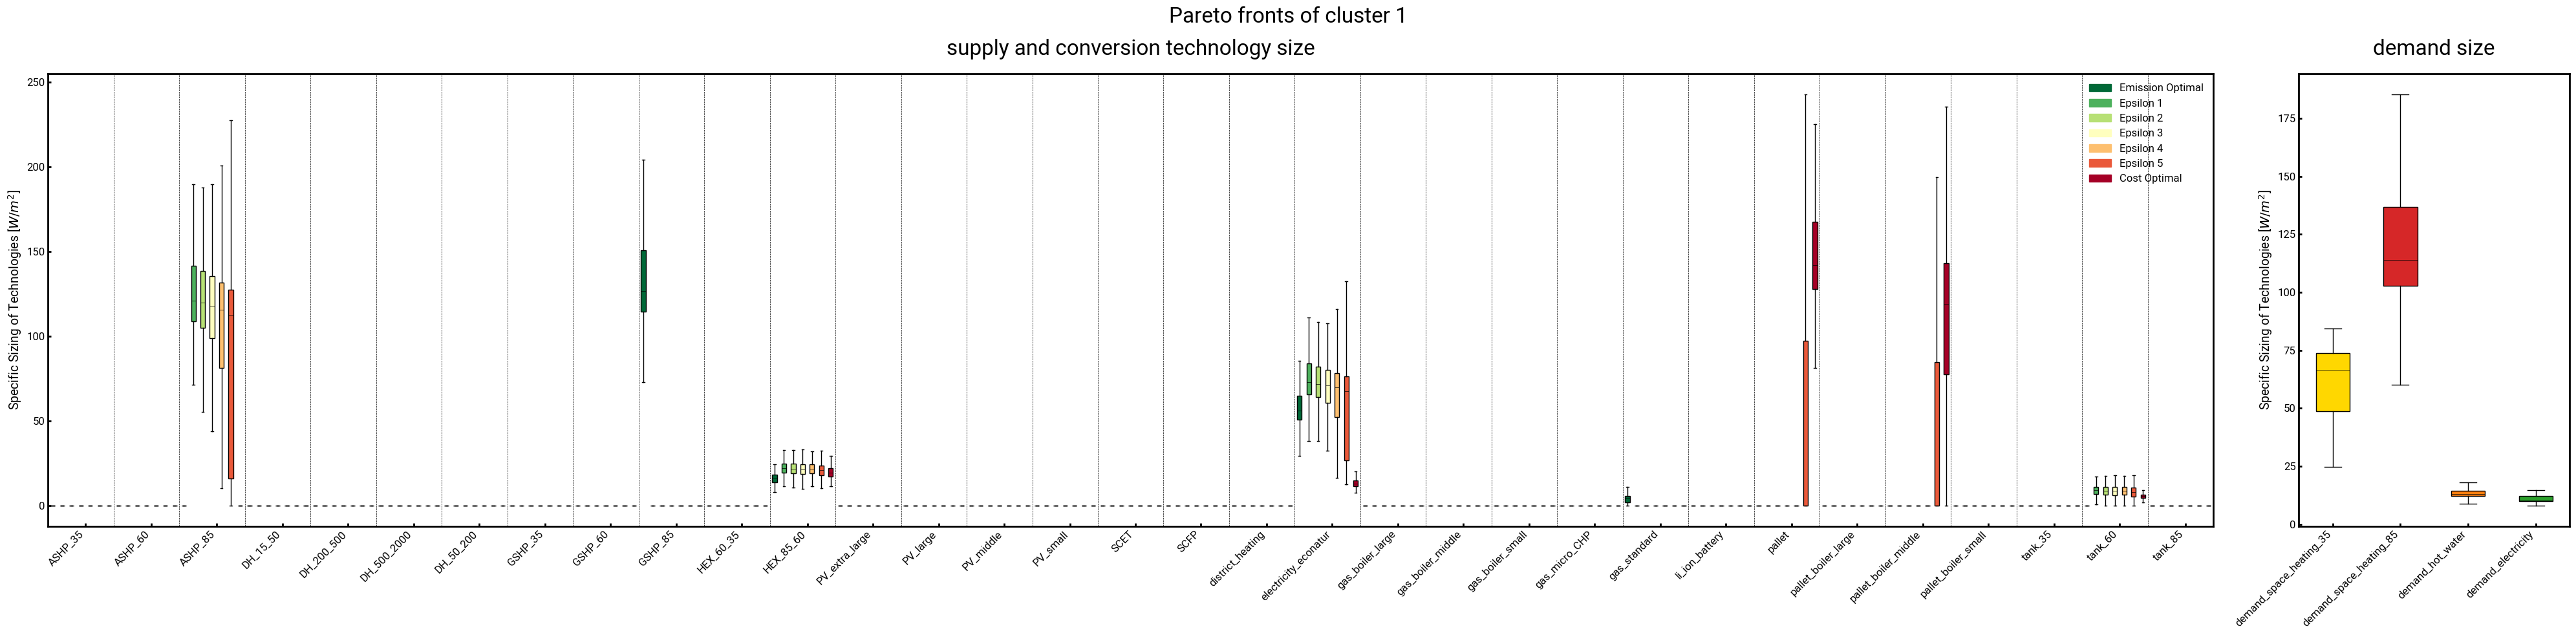

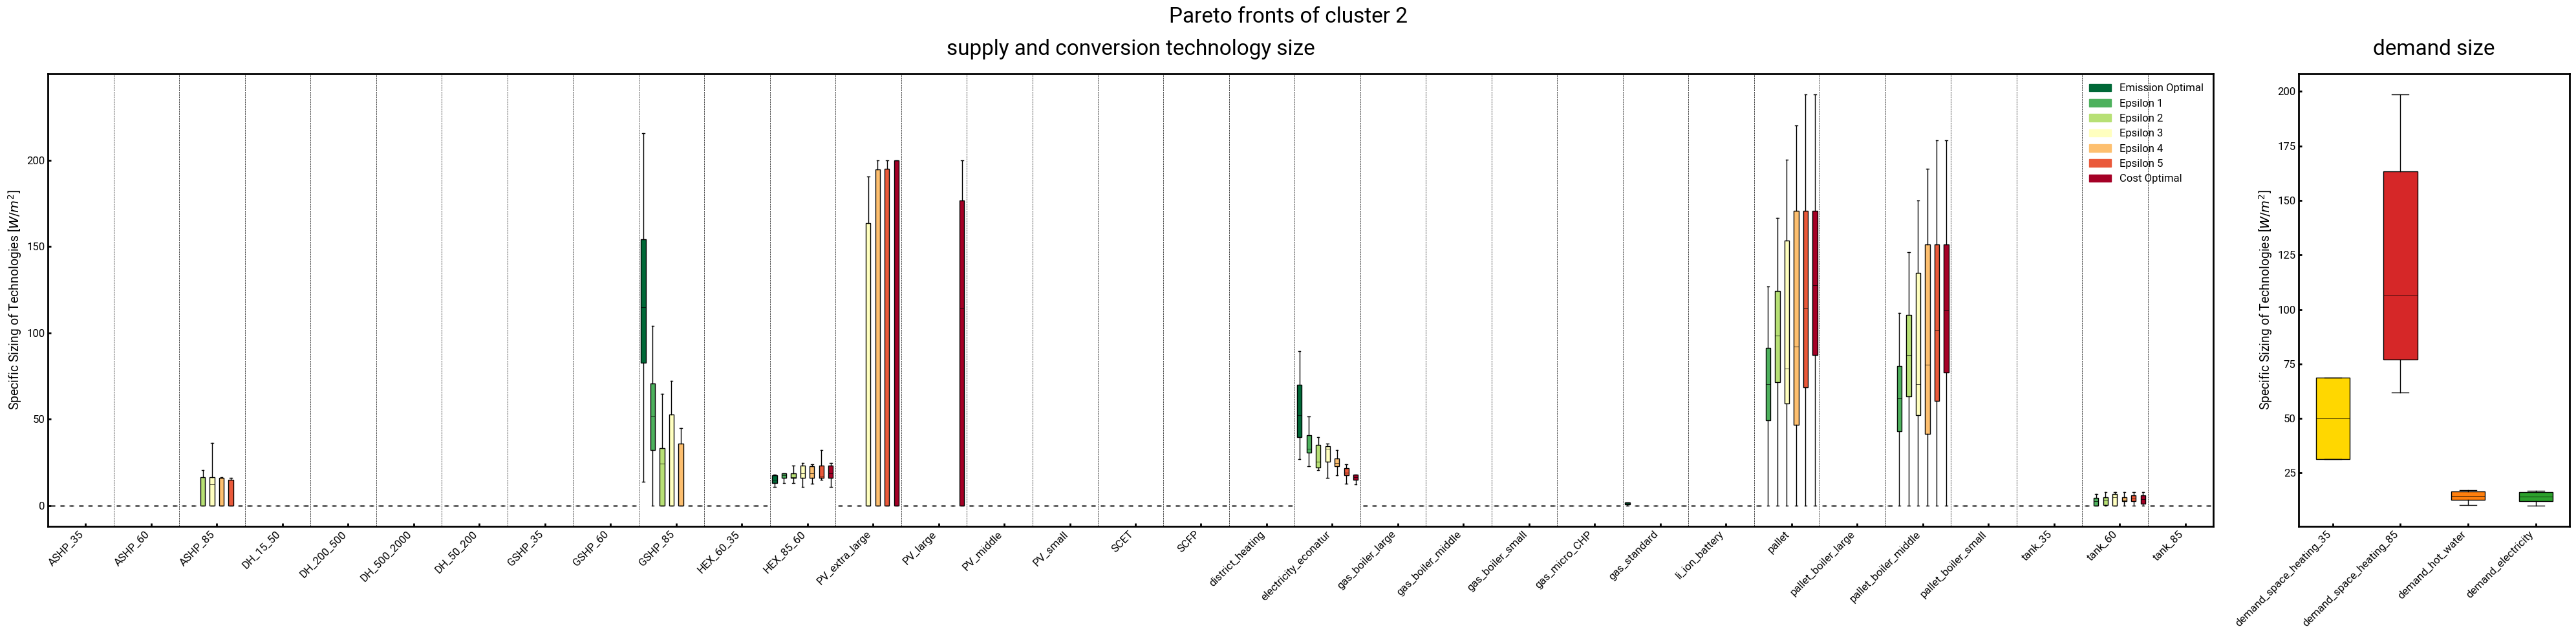

In [ ]:
from trustParetoFronts.pareto_front_plots import tech_size_boxplot

if with_oil:
    title_3 = "Pareto fronts of all buildings for scenario with oil"
else:
    title_3 = "Pareto fronts of all buildings for scenario without oil"
tech_size_boxplot(
    df_pareto_all,
    ls_supply_name,
    demand_color_dict,
    title_left="supply and conversion technology size",
    title_right="demand size",
    title_fig=title_3,
    figsize=(40, 10),
    width_ratios=(8, 1),
)

df_pareto_0 = df_pareto_all[df_pareto_all["cluster"] == 0]
df_pareto_1 = df_pareto_all[df_pareto_all["cluster"] == 1]
df_pareto_2 = df_pareto_all[df_pareto_all["cluster"] == 2]

tech_size_boxplot(
    df_pareto_0,
    ls_supply_name,
    demand_color_dict,
    title_left="supply and conversion technology size",
    title_right="demand size",
    title_fig="Pareto fronts of cluster 0",
    figsize=(40, 10),
    width_ratios=(8, 1),
)

tech_size_boxplot(
    df_pareto_1,
    ls_supply_name,
    demand_color_dict,
    title_left="supply and conversion technology size",
    title_right="demand size",
    title_fig="Pareto fronts of cluster 1",
    figsize=(40, 10),
    width_ratios=(8, 1),
)

tech_size_boxplot(
    df_pareto_2,
    ls_supply_name,
    demand_color_dict,
    title_left="supply and conversion technology size",
    title_right="demand size",
    title_fig="Pareto fronts of cluster 2",
    figsize=(40, 10),
    width_ratios=(8, 1),
)

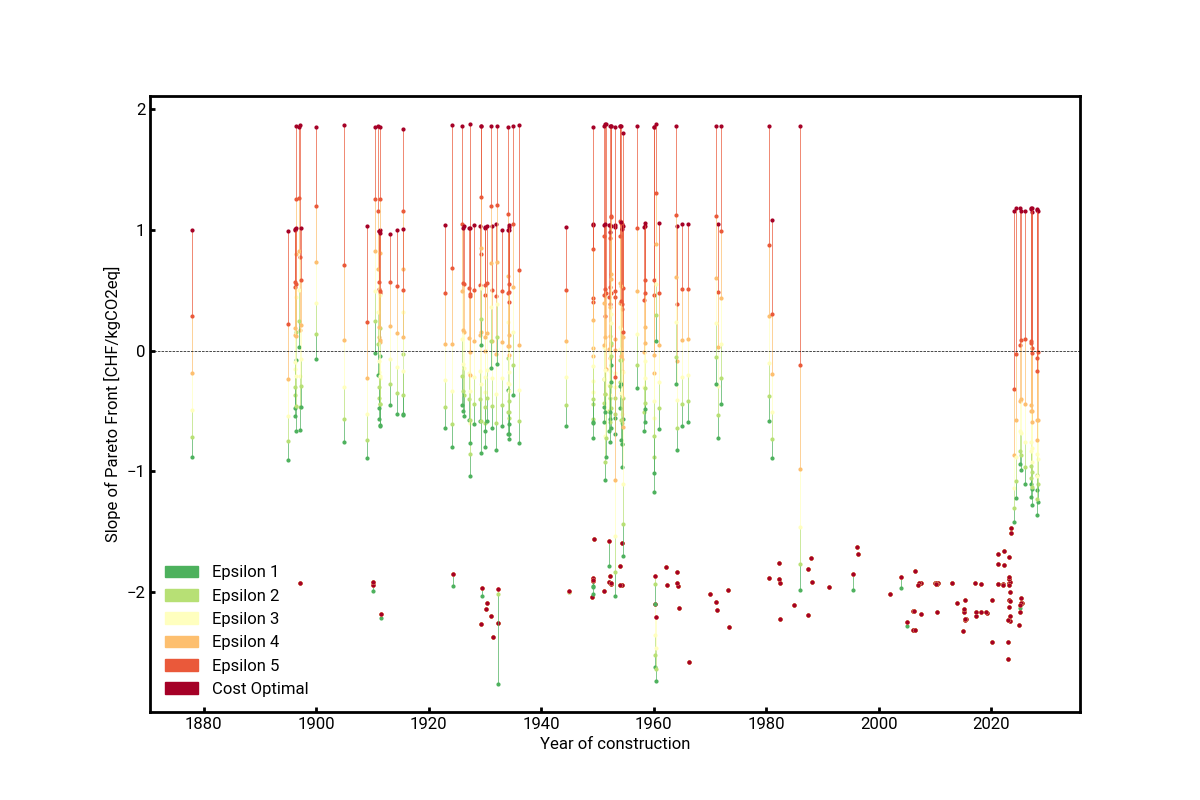

In [ ]:
# in df_tech_cap, add one more column to describe the slope of current status to each point of the pareto front
# first, initialize the column slope with 0
fig4, ax = plt.subplots()
for name in df_tech_cap.index.get_level_values("building").unique():
    df_pareto = df_tech_cap.loc[name].copy()
    df_pareto = df_pareto.assign(
        slope=(df_pareto["cost"] - df_pareto.loc[999, "cost"])
        / (df_pareto["emission"] - df_pareto.loc[999, "emission"])
    )
    df_pareto = df_pareto.replace([np.inf, -np.inf], np.nan).fillna(0)
    # if [999, slope] == 0, then assign it with the value of [-3, slope]
    if df_pareto["slope"].iloc[-2] - 0 < 1e-4:
        df_pareto["slope"].iloc[-2] = df_pareto["slope"].iloc[-3]
    # delete the first row of the dataframe, because it's the emission minimal, thus cost maximal, we ignore this point because it's highly unlikely to be chosen
    building_year: np.int64 = zone_df.loc[name, "YEAR"]  # type: ignore
    # if building_year is duplicated, then add a small random number to it
    if (zone_df["YEAR"] == building_year).sum() > 1:
        building_year += np.random.rand() * 0.5
    # collect the arrowhead artist for each building
    for idx, slope in enumerate(df_pareto["slope"].iloc[1:-2]):
        idx = idx + 1
        # plot the line pointing from the previous slope to the current slope
        x = [building_year, building_year]
        y = [df_pareto.loc[idx, "slope"], df_pareto.loc[idx + 1, "slope"]]
        ax.plot(x, y, color=cmap(idx), linewidth=0.5)
        ax.plot(
            building_year,
            df_pareto.loc[idx, "slope"],
            color=cmap(idx),
            marker="o",
            markersize=2,
        )
    # plot the last point
    ax.plot(
        building_year,
        df_pareto["slope"].iloc[-2],
        color=cmap(n_epsilon - 1),
        marker="o",
        markersize=2,
    )

# add legend
ax.legend(handles=legend_patches[1:], loc="best")
ax.set_xlabel("Year of construction")
ax.set_ylabel("Slope of Pareto Front [CHF/kgCO2eq]")
ax.axhline(0, color="black", linewidth=0.5, linestyle="--")